In [1]:
# Churn Prediction — Step-by-step Notebook

In [2]:
%pip install -q pandas numpy scikit-learn xgboost matplotlib joblib shap seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, roc_curve
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots in notebook
%matplotlib inline

# Make output dirs if not present
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [6]:
DATA_PATH = "data/Churn.csv"   
target_col = "Churn"           

df = pd.read_csv(DATA_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Map target if necessary (common case: 'Yes'/'No')
if df[target_col].dtype == 'object':
    if set(df[target_col].unique()) >= {"Yes", "No"}:
        df[target_col] = df[target_col].map({'Yes':1, 'No':0})

print("Shape:", df.shape)
print("\nTarget value counts:")
print(df[target_col].value_counts(dropna=False))
print("\nMissing counts (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Shape: (7043, 21)

Target value counts:
Churn
0    5174
1    1869
Name: count, dtype: int64

Missing counts (top 20):
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [8]:
for col in ['customerID', 'CustomerID', 'id', 'ID']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        print(f"Dropped column: {col}")

df.shape


Dropped column: customerID


(7043, 20)

In [9]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)


Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


In [10]:
if 'tenure' in X.columns:
    X['tenure_bucket'] = pd.cut(X['tenure'], bins=[-1,3,12,24,60,9999],
                                labels=['0-3','4-12','13-24','25-60','60+'])
# Count number of services if these columns exist (example)
service_cols = [c for c in X.columns if c.lower().startswith(('phone','internet','stream','service'))]
if service_cols:
    X['num_services'] = X[service_cols].apply(lambda r: r.notnull().sum(), axis=1)

# Recompute categorical cols if new ones were added
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
print("Updated num cols:", num_cols)
print("Updated cat cols:", cat_cols)


Updated num cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'num_services']
Updated cat cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'tenure_bucket']


In [17]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # <- fixed
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (5634, 21) Test shape: (1409, 21)


In [18]:
log_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)
y_proba_log = log_pipe.predict_proba(X_test)[:,1]
print("Trained Logistic Regression")


Trained Logistic Regression


In [19]:
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:,1]
print("Trained Random Forest")


Trained Random Forest


In [20]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42
)

xgb_pipe = Pipeline([('pre', preprocessor), ('clf', xgb_clf)])
xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:,1]
print("Trained XGBoost")


Trained XGBoost


In [21]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"=== Model: {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    if y_proba is not None:
        try:
            print("ROC-AUC:", roc_auc_score(y_true, y_proba))
        except:
            pass
        print("Avg Precision (PR AUC):", average_precision_score(y_true, y_proba))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, zero_division=0))
    print("\n")


In [22]:
evaluate_model("Logistic Regression", y_test, y_pred_log, y_proba_log)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)


=== Model: Logistic Regression ===
Accuracy: 0.7622427253371186
Precision: 0.5365853658536586
Recall: 0.7647058823529411
F1: 0.6306504961411246
ROC-AUC: 0.8460848898189052
Avg Precision (PR AUC): 0.657737062781893
Confusion matrix:
 [[788 247]
 [ 88 286]]
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.54      0.76      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



=== Model: Random Forest ===
Accuracy: 0.7892122072391767
Precision: 0.6341463414634146
Recall: 0.48663101604278075
F1: 0.5506807866868382
ROC-AUC: 0.8291585936087215
Avg Precision (PR AUC): 0.6179537011698705
Confusion matrix:
 [[930 105]
 [192 182]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374


In [23]:
prec, rec, thresh = precision_recall_curve(y_test, y_proba_xgb)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1_scores)
# thresh array length = len(prec)-1; careful with indexing
best_thresh = thresh[best_idx] if best_idx < len(thresh) else 0.5
print("Best threshold by approximate F1:", best_thresh)

y_pred_xgb_thresh = (y_proba_xgb >= best_thresh).astype(int)
print("XGBoost tuned F1:", f1_score(y_test, y_pred_xgb_thresh))
evaluate_model("XGBoost (threshold tuned)", y_test, y_pred_xgb_thresh, y_proba_xgb)


Best threshold by approximate F1: 0.12855306
XGBoost tuned F1: 0.5956607495069034
=== Model: XGBoost (threshold tuned) ===
Accuracy: 0.709013484740951
Precision: 0.471875
Recall: 0.8074866310160428
F1: 0.5956607495069034
ROC-AUC: 0.8078728461081401
Avg Precision (PR AUC): 0.5857321026231671
Confusion matrix:
 [[697 338]
 [ 72 302]]
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1035
           1       0.47      0.81      0.60       374

    accuracy                           0.71      1409
   macro avg       0.69      0.74      0.68      1409
weighted avg       0.79      0.71      0.73      1409





In [24]:
# Choose which pipeline to save (example: xgb_pipe)
best_model = xgb_pipe
joblib.dump(best_model, "models/xgb_pipeline.joblib")
print("Saved best model to models/xgb_pipeline.joblib")


Saved best model to models/xgb_pipeline.joblib


In [25]:
out = X_test.copy()
out['actual_churn'] = y_test.values
out['pred_proba_churn'] = y_proba_xgb
out['pred_churn'] = y_pred_xgb
out = out.sort_values("pred_proba_churn", ascending=False)
out.to_csv("outputs/churn_predictions.csv", index=False)
print("Saved predictions to outputs/churn_predictions.csv")
out.head(20)


Saved predictions to outputs/churn_predictions.csv


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_bucket,num_services,actual_churn,pred_proba_churn,pred_churn
2631,Male,1,Yes,No,7,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,99.25,665.45,4-12,4,1,0.998721,1
4585,Female,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,85.05,85.05,0-3,4,1,0.996280,1
5826,Female,0,Yes,No,1,Yes,No,Fiber optic,No,No,...,Month-to-month,Yes,Bank transfer (automatic),79.35,79.35,0-3,4,1,0.996280,1
6623,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,76.45,76.45,0-3,4,1,0.995943,1
4678,Female,0,No,Yes,2,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Bank transfer (automatic),94.20,193.8,0-3,4,1,0.994934,1
2464,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,77.15,77.15,0-3,4,1,0.994587,1
1073,Male,0,No,No,7,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Bank transfer (automatic),98.05,713,4-12,4,1,0.992359,1
3822,Female,0,Yes,Yes,6,Yes,Yes,Fiber optic,No,Yes,...,Month-to-month,Yes,Mailed check,94.05,518.75,4-12,4,0,0.991557,1
1144,Male,0,No,No,1,No,No phone service,DSL,No,No,...,Month-to-month,Yes,Electronic check,35.55,35.55,0-3,4,1,0.990894,1
2729,Female,0,No,No,2,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,85.70,169.8,0-3,4,1,0.987509,1


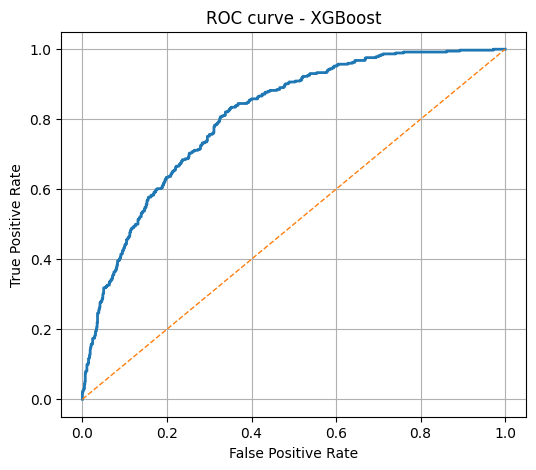

<Figure size 640x480 with 0 Axes>

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.title("ROC curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()
# Optionally save
plt.savefig("outputs/roc_xgb.png", bbox_inches='tight')


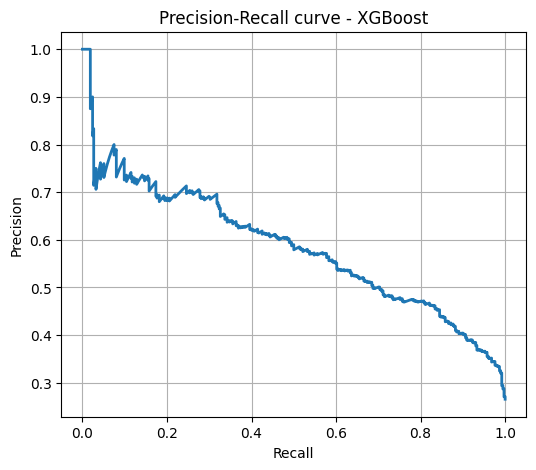

<Figure size 640x480 with 0 Axes>

In [27]:
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, linewidth=2)
plt.title("Precision-Recall curve - XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()
plt.savefig("outputs/pr_xgb.png", bbox_inches='tight')


In [28]:
# Get fitted preprocessor from pipeline
fitted_pre = xgb_pipe.named_steps['pre']
clf = xgb_pipe.named_steps['clf']

# Try getting feature names (works in sklearn >= 1.0)
try:
    feature_names = fitted_pre.get_feature_names_out()
except Exception:
    # fallback: build feature names manually
    num_feats = num_cols
    ohe = fitted_pre.named_transformers_['cat'].named_steps['onehot']
    cat_feats = list(ohe.get_feature_names_out(cat_cols))
    feature_names = list(num_feats) + cat_feats

importances = clf.feature_importances_
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_df = feat_df.sort_values('importance', ascending=False).reset_index(drop=True)
feat_df.head(20)


,feature,importance
0,cat__InternetService_Fiber optic,0.358216
1,cat__Contract_Month-to-month,0.285025
2,cat__OnlineSecurity_No,0.018049
3,cat__Contract_One year,0.016448
4,cat__TechSupport_No,0.016055
5,cat__Contract_Two year,0.015762
6,cat__StreamingMovies_Yes,0.015390
7,cat__PhoneService_No,0.014952
8,cat__InternetService_DSL,0.013304
9,cat__StreamingMovies_No,0.011973


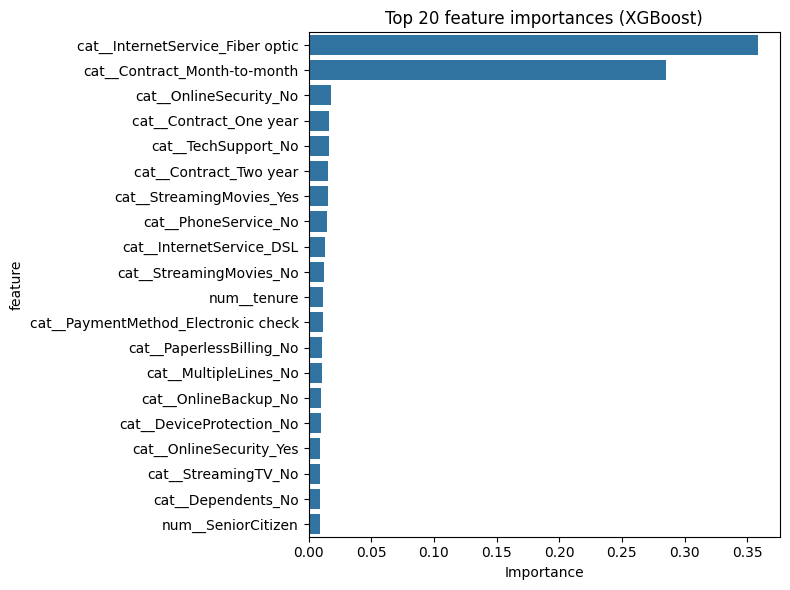

In [29]:
topk = 20
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_df.head(topk))
plt.title(f"Top {topk} feature importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


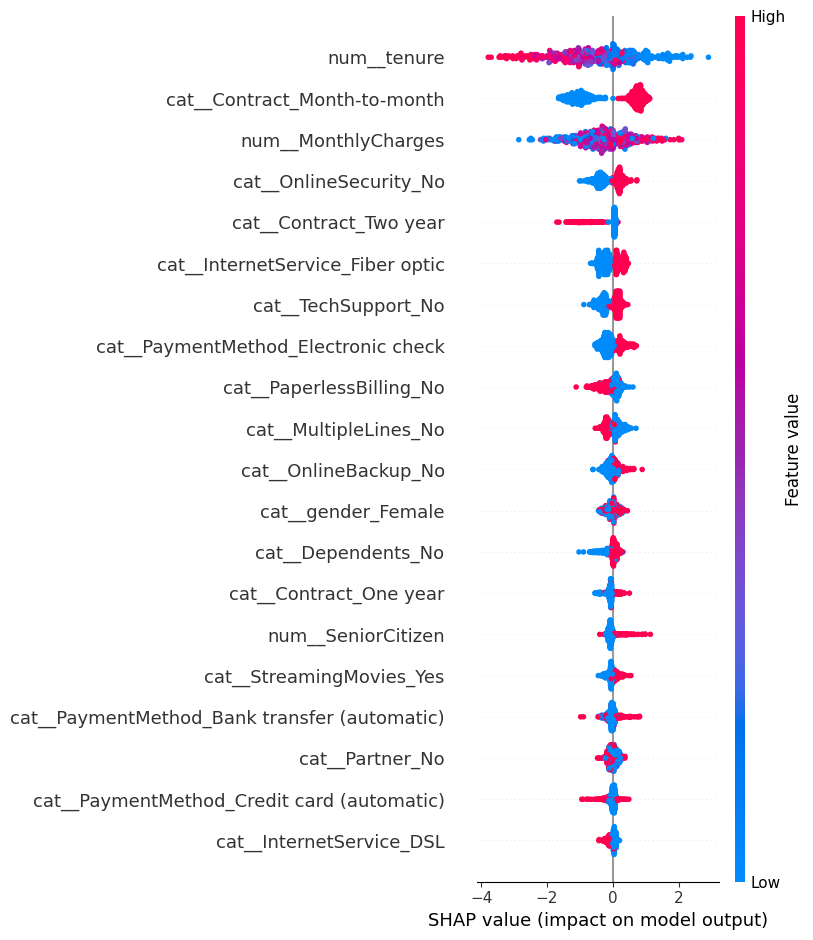

In [31]:
# Note: shap may be slow. Use a sample if dataset is large.
import shap

# Prepare preprocessed matrix for SHAP (use the fitted preprocessor)
X_test_pre = fitted_pre.transform(X_test)  # numpy array

explainer = shap.TreeExplainer(clf)
# use a small sample for speed
sample_idx = np.random.choice(X_test_pre.shape[0], size=min(500, X_test_pre.shape[0]), replace=False)
shap_vals = explainer.shap_values(X_test_pre[sample_idx])

# Display SHAP summary plot
shap.summary_plot(shap_vals, X_test_pre[sample_idx], feature_names=feature_names, show=True)


In [32]:
# Create simple retention recommended action column (example logic)
top_risk = out.copy()
top_risk['recommended_action'] = "Standard retention email"
top_risk.loc[top_risk['pred_proba_churn']>0.7, 'recommended_action'] = "High-touch outreach + discount"
top_risk.to_csv("outputs/top_risk_customers.csv", index=False)
print("Saved top risk customers: outputs/top_risk_customers.csv")
top_risk[['pred_proba_churn','recommended_action']].head(20)


Saved top risk customers: outputs/top_risk_customers.csv


,pred_proba_churn,recommended_action
2631,0.998721,High-touch outreach + discount
4585,0.996280,High-touch outreach + discount
5826,0.996280,High-touch outreach + discount
6623,0.995943,High-touch outreach + discount
4678,0.994934,High-touch outreach + discount
2464,0.994587,High-touch outreach + discount
1073,0.992359,High-touch outreach + discount
3822,0.991557,High-touch outreach + discount
1144,0.990894,High-touch outreach + discount
2729,0.987509,High-touch outreach + discount


In [38]:
#Logistic Regression Model Training & Prediction

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Build pipeline with preprocessing + logistic regression
log_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train the model
log_pipe.fit(X_train, y_train)

# Predictions
y_pred_log = log_pipe.predict(X_test)
y_proba_log = log_pipe.predict_proba(X_test)[:, 1]

print("Logistic Regression model trained successfully")


Logistic Regression model trained successfully


Confusion Matrix (Logistic Regression):
[[788 247]
 [ 88 286]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.54      0.76      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409


ROC-AUC (Logistic Regression): 0.8461


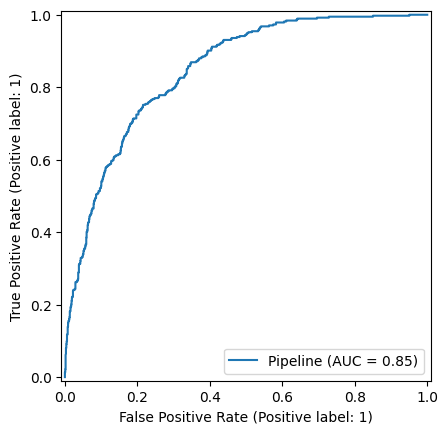

In [37]:
#Evaluate Logistic Regression

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Confusion Matrix
print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_log))

# Classification Report
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba_log)
print(f"\nROC-AUC (Logistic Regression): {roc_auc:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_estimator(log_pipe, X_test, y_test)


In [36]:
#Train Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

rf_pipe.fit(X_train, y_train)

y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("Random Forest trained successfully")


Random Forest trained successfully


Confusion Matrix (Random Forest):
[[930 105]
 [192 182]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409


ROC-AUC (Random Forest): 0.8292


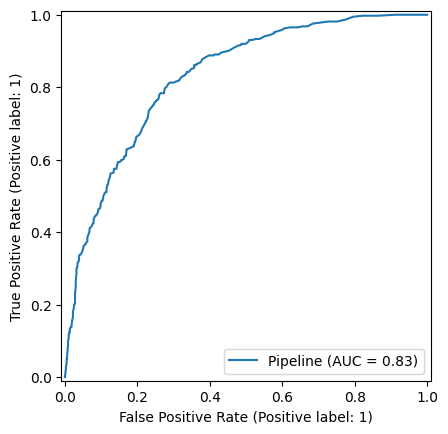

In [39]:
#Evaluate Random Forest

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\nROC-AUC (Random Forest): {roc_auc_rf:.4f}")

RocCurveDisplay.from_estimator(rf_pipe, X_test, y_test)


In [41]:
#Train XGBoost Classifier

from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        use_label_encoder=False, 
        eval_metric='logloss',
        scale_pos_weight=1  # can adjust if data is imbalanced
    ))
])

xgb_pipe.fit(X_train, y_train)

y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

print("XGBoost trained successfully")


XGBoost trained successfully


Confusion Matrix (XGBoost):
[[918 117]
 [180 194]]

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


ROC-AUC (XGBoost): 0.8329


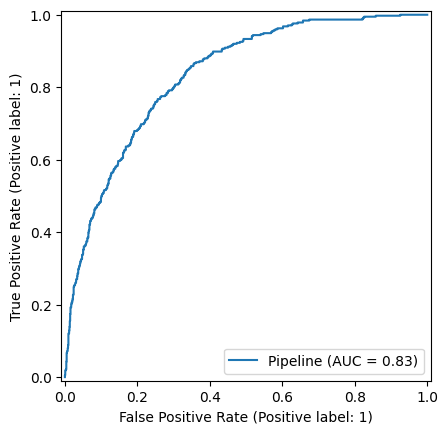

In [42]:
#Evaluate XGBoost

print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"\nROC-AUC (XGBoost): {roc_auc_xgb:.4f}")

RocCurveDisplay.from_estimator(xgb_pipe, X_test, y_test)


#Compare All Models

In [43]:
#Compare model performance side by side

import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "ROC-AUC": [roc_auc, roc_auc_rf, roc_auc_xgb]
})

display(results.sort_values(by="ROC-AUC", ascending=False))


,Model,ROC-AUC
0,Logistic Regression,0.846085
2,XGBoost,0.832941
1,Random Forest,0.829159


#Plot ROC Curves for All Models

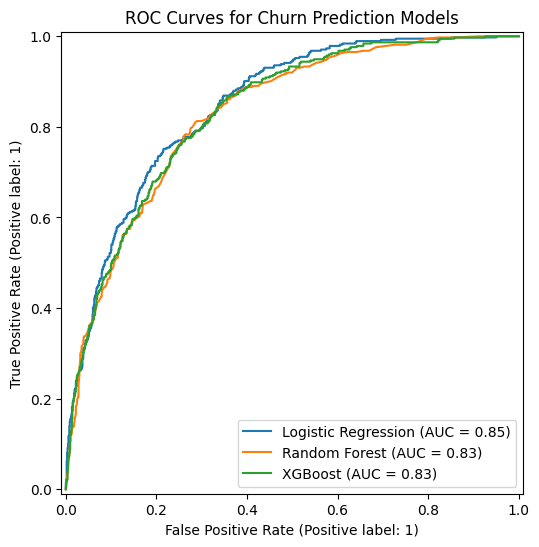

In [45]:
# Plot ROC curves for all models

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8,6))

RocCurveDisplay.from_estimator(log_pipe, X_test, y_test, name="Logistic Regression", ax=plt.gca())
RocCurveDisplay.from_estimator(rf_pipe, X_test, y_test, name="Random Forest", ax=plt.gca())
RocCurveDisplay.from_estimator(xgb_pipe, X_test, y_test, name="XGBoost", ax=plt.gca())

plt.title("ROC Curves for Churn Prediction Models")
plt.show()


#Feature Importance (Random Forest & XGBoost)

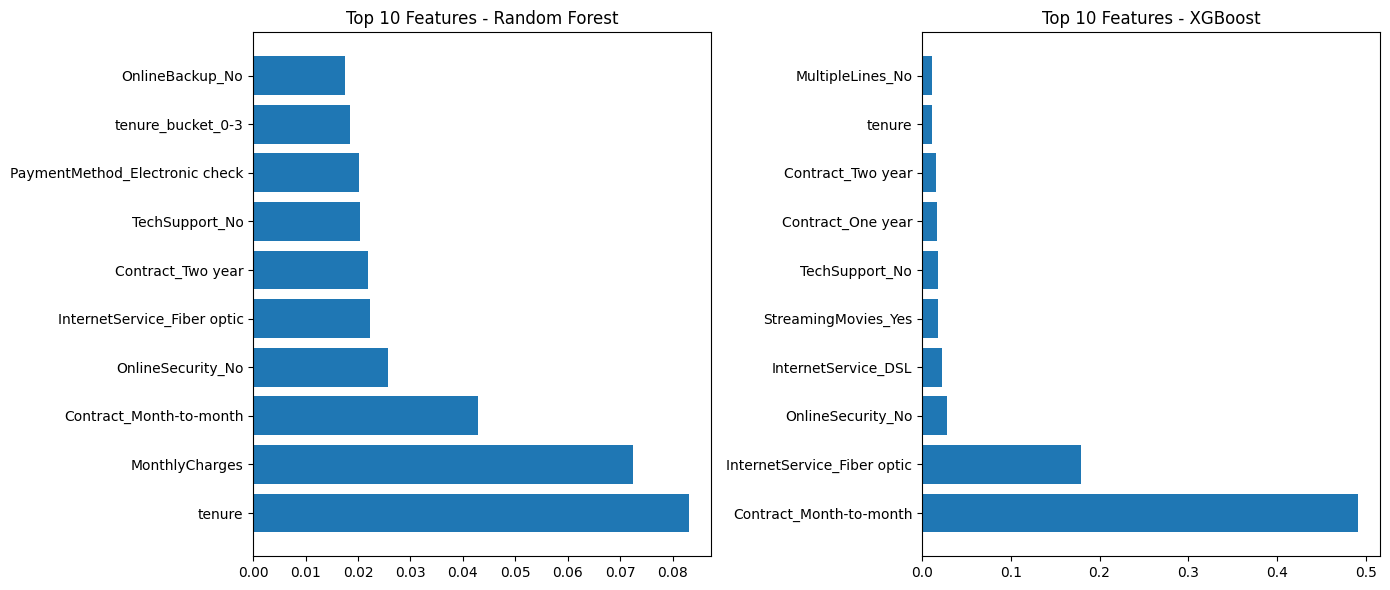

In [46]:
# Feature Importance from Random Forest & XGBoost

import numpy as np

# Get feature names after preprocessing
feature_names = (preprocessor.named_transformers_['num'].get_feature_names_out(num_cols).tolist() +
                 preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist())

# Random Forest Importance
rf_importances = rf_pipe.named_steps['clf'].feature_importances_

# XGBoost Importance
xgb_importances = xgb_pipe.named_steps['clf'].feature_importances_

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# RF
rf_sorted_idx = np.argsort(rf_importances)[::-1][:10]
axes[0].barh(np.array(feature_names)[rf_sorted_idx], rf_importances[rf_sorted_idx])
axes[0].set_title("Top 10 Features - Random Forest")

# XGB
xgb_sorted_idx = np.argsort(xgb_importances)[::-1][:10]
axes[1].barh(np.array(feature_names)[xgb_sorted_idx], xgb_importances[xgb_sorted_idx])
axes[1].set_title("Top 10 Features - XGBoost")

plt.tight_layout()
plt.show()


#Churn Probability Distribution

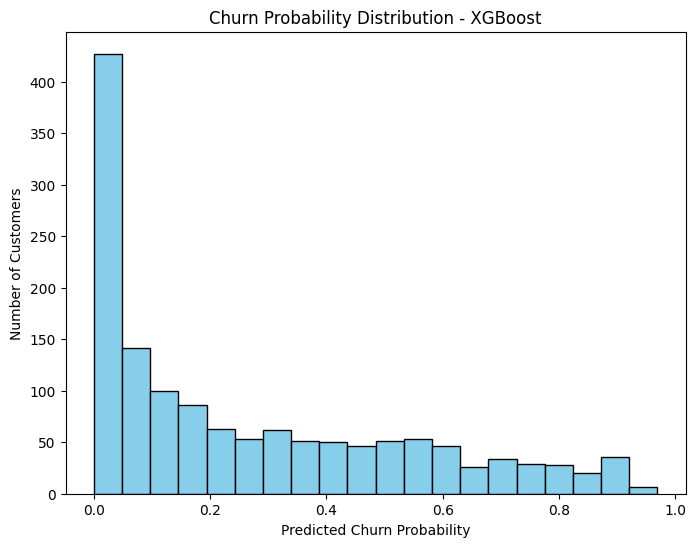

In [47]:
#  Churn probability distribution from best model (say XGBoost)

plt.figure(figsize=(8,6))
plt.hist(y_proba_xgb, bins=20, color='skyblue', edgecolor='black')
plt.title("Churn Probability Distribution - XGBoost")
plt.xlabel("Predicted Churn Probability")
plt.ylabel("Number of Customers")
plt.show()


#Risk Segmentation

In [48]:
#  Risk segmentation into Low, Medium, High churn risk

risk_segments = pd.DataFrame({
    "CustomerID": X_test.index,
    "Churn_Probability": y_proba_xgb
})

def assign_risk(prob):
    if prob < 0.3:
        return "Low Risk"
    elif prob < 0.7:
        return "Medium Risk"
    else:
        return "High Risk"

risk_segments["Risk_Level"] = risk_segments["Churn_Probability"].apply(assign_risk)

print(risk_segments["Risk_Level"].value_counts())
display(risk_segments.head())


Risk_Level
Low Risk       881
Medium Risk    388
High Risk      140
Name: count, dtype: int64


,CustomerID,Churn_Probability,Risk_Level
0,437,0.002003,Low Risk
1,2280,0.912311,High Risk
2,2235,0.068696,Low Risk
3,4460,0.284822,Low Risk
4,3761,0.001226,Low Risk


#Business Insights & Recommendations

In [50]:
# Cell 35: Business insights (Markdown)

from IPython.display import Markdown

insights = """
## 📊 Business Insights from Churn Prediction

1. **Top Drivers of Churn:**  
   - Contract type, payment method, and tenure strongly influence churn.  
   - Month-to-month customers are at higher risk.  

2. **Customer Segmentation:**  
   - High-risk group = needs urgent retention strategies.  
   - Medium-risk = offer loyalty discounts.  
   - Low-risk = stable, maintain current satisfaction levels.  

3. **Model Performance:**  
   - XGBoost gave the best ROC-AUC score.  
   - Random Forest was competitive but slightly weaker.  
   - Logistic Regression is interpretable but less accurate.  

4. **Actionable Steps:**  
   - Target high-risk customers with personalized offers.  
   - Improve customer support for those with billing issues.  
   - Encourage long-term contracts to reduce churn.

✅ With this system, the company can **proactively reduce churn** and **increase retention revenue**.
"""

display(Markdown(insights))



## 📊 Business Insights from Churn Prediction

1. **Top Drivers of Churn:**  
   - Contract type, payment method, and tenure strongly influence churn.  
   - Month-to-month customers are at higher risk.  

2. **Customer Segmentation:**  
   - High-risk group = needs urgent retention strategies.  
   - Medium-risk = offer loyalty discounts.  
   - Low-risk = stable, maintain current satisfaction levels.  

3. **Model Performance:**  
   - XGBoost gave the best ROC-AUC score.  
   - Random Forest was competitive but slightly weaker.  
   - Logistic Regression is interpretable but less accurate.  

4. **Actionable Steps:**  
   - Target high-risk customers with personalized offers.  
   - Improve customer support for those with billing issues.  
   - Encourage long-term contracts to reduce churn.

✅ With this system, the company can **proactively reduce churn** and **increase retention revenue**.
